<img style="float:right; max-width:300px" src="imgs/time series.jpg" width="60%" />

# Analiza vremenske serije
Vremenska serija je kolekcija observacija $x_t$ ureƒëenih po vremenu. Na osnovu nezavisne promenljive $x$, koja predstavlja vreme, ≈æelimo da predvidimo zavisnu promenljivu $y$. Razlika u odnosu na dosada≈°nju linearnu regresiju je ≈°to podaci nisu linearni, i ≈æelimo da koristimo informacije o prethodnim observacijama ($y_t$ ne zavisi samo od trenutnog $x_t$, veƒá i od prethodnih observacija $x_{t-1}$, ...). Predviƒëamo taƒçke van poznatog opsega, pa koristimo ekstrapolaciju.

Za poƒçetak, uƒçitavamo neophodne pakete i skup podataka:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import statsmodels.api as sm

matplotlib.rcParams['figure.figsize'] = (8, 4)
sb.set(font_scale=1.)

df = pd.read_csv('data/airline-passengers.csv', sep=',')
print(df.dtypes)
df.head()

Month         object
Passengers     int64
dtype: object


Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121

Konvertujemo kolonu `Month` iz tipa `object` u tip `datetime` i postavljamo je kao indeks (radi lak≈°e manipulacije podacima). Zatim izdvajamo vreme (u mesecima) u nezavisnu promenljivu $x$, a broj putnika koji su leteli u svakom mesecu u zavisnu promenljivu $y$.

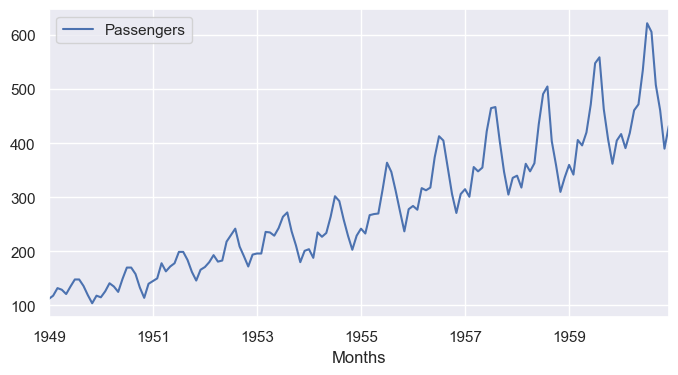

In [2]:
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')

df.plot();
# ekvivalentno sa:
x, y = df.index, df['Passengers']
plt.plot(x, y); plt.xlabel('Months');

## Autokorelacija
Autokorelacija slu≈æi da proverimo da li postoji ≈°ablon u podacima.
Da bismo mogli da modelujemo vremensku seriju, mora postojati autokorelacija.
Pozitivna autokorelacija znaƒçi da vrednosti $y$ opadaju (ili rastu) zajedno, dok negativna autokorelacija znaƒçi da vrednosti $y$ opadaju (ili rastu) suprotno.
Ako nema autokorelacije, to znaƒçi da se vrednosti menjaju na sluƒçajan naƒçin kroz vreme i da ne mo≈æemo pronaƒái ≈°ablon u podacima ‚û°Ô∏è tada problem ne mo≈æemo re≈°iti algoritmima vremenske serije.

### Autokorelogram
Autokorelaciju tumaƒçimo preko autokorelograma.
Autokorelogram (eng. *autocorrelation function* ili *ACF*) je grafik autokorelacije. Koristimo funkciju `plot_acf()` da nacrtamo grafik.
Na x-osi je vremenski razmak $k$ izmeƒëu dve observacije. Na y-osi je koeficijent autokorelacije za vremenski razmak $k$.

Vrednosti unutar osenƒçenog dela su beznaƒçajne ‚û°Ô∏è sa 95% pouzdanosti nema autokorelacije za trenutno $k$.
Vrednosti van osenƒçenog dela su znaƒçajne, odnosno postoji autokorelacija (koliko je jaka, to govori koeficijent autokorelacije).
Ukoliko na grafiku dobijemo da su (skoro) sve vrednosti unutar osenƒçenog dela ‚û°Ô∏è onda nema autokorelacije; verovatno ne postoji ≈°ablon u podacima veƒá su podaci ≈°um.

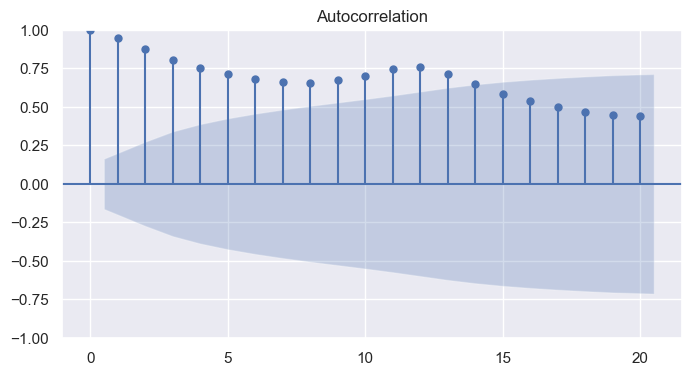

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Passengers'], lags=20)
plt.show()

<img style="float:right; max-width:400px" src="imgs/acf_pacf.png" width="60%" />

Tumaƒçenje: Sa grafika vidimo da posle $k=14$ ne postoji autokorelacija; vrednosti su beznaƒçajne. Visoka ACF vrednost za $k=2$ ukazuje na jak uticaj pretpro≈°log meseca na trenutni. Npr. ako broj putnika u januaru raste (opada) onda broj putnika u martu raste (opada) zbog pozitivne autokorelacije. Na osnovu broja putnika u januaru mo≈æemo predvideti broj putnika u martu.

Moguƒáe je da broj putnika u januaru nema direktan uticaj na mart, veƒá na februar koji utiƒçe na mart - ovo je indirektan uticaj.
**Autokorelacija meri direktan i indirektan uticaj** pretpro≈°log meseca na trenutni.
Meƒëutim, ako nas zanima direktan uticaj *broja putnika u januaru* na *broj putnika u martu* (preskaƒçemo februar), koristimo *parcijalnu autokorelaciju*.

### Parcijalna autokorelacija
Autokorelacija meri direktan i indirektan uticaj, dok parcijalna autokorelacija meri samo direktan uticaj (eng. *partial autocorrelation function - PACF*). Da izmerimo samo direktan uticaj koristimo *PACF*.

**Tumaƒçenje:** Sa sledeceg grafika vidimo da samo nekoliko vrednosti za $k$ ima veliku PACF vrednost. Za k=2, primeƒáujemo znaƒçajnu vrednost, ali gotovo na granici, ≈°to ukazuje na relativno slab direktni uticaj prepro≈°log meseca na trenutni mesec.

**ACF vs PACF:** S obzirom na veliku ACF vrednost za $k=2$ i manju PACF vrednost ‚û°Ô∏è pretpro≈°li mesec ima jak indirektan, ali slab direktni uticaj na broj putnika u trenutnom mesecu. Visoka ACF vrednost za $k=2$ sugeri≈°e da mo≈æemo predviƒëati broj putnika u martu, ako znamo broj putnika u januaru i februaru. S druge strane, znaƒçajna PACF vrednost za $k=2$ ukazuje da mo≈æemo predviƒëati broj putnika u martu na osnovu broja putnika u januaru (preskaƒçemo februaru). Ipak, s obzirom da je PACF vrednost na granici, predikcije za mart samo na osnovu januara ƒáe biti manje precizne.

**PACF za analizu vs PACF za predikcije:**
PACF primenjujemo nad nestacionarnom podacima (obja≈°njeno u nastavku) **za analizu** vremenske serije. Nestacionarni podaci imaju komponente (trend i sezonalnost) koje indirektno utiƒçu na vrednosti PACF. PACF ne otklanja ovaj indirektan uticaj komponenti.
PACF grafik ƒáemo koristi i u kontekstu **predikcije modela** (radimo u sledeƒáem terminu), a tada ƒáemo PACF upotrebiti nad stacionarnim podacima i vrednosti koeficijenata ƒáe se razlikovati (PACF nad nestacionarnim podacima nema iste vrednosti kao PACF nad stacionarnim podacima).

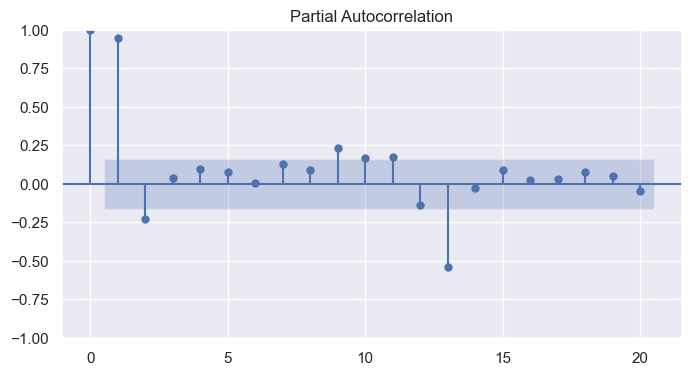

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['Passengers'], lags=20)
plt.show()

<img style="float:right; max-width:400px" src="imgs/components.jpg" width="60%" />

## Komponente vremenske serije
Vremenska serija sastoji se od vi≈°e komponenti (komponente - obrasci koji utiƒçu na pona≈°anje vremenske serije). 
4 glavne komponente su: **trend, sezonalnost, cikliƒçnost i reziduali (≈°um)**.
Da bismo analizirali vremensku seriju, razdvajamo je na komponente. 
*Napomena: cikliƒçnost se ne pojavljuje u redovnim intervalima i oblik nije uniforman kao kod sezonalnosti, ≈°to ote≈æava njeno detektovanje kao zasebnu komponentu. Zbog toga je ƒçesto identifikujemo unutar trenda, umesto kao samostalnu komponentu.*

Da bismo seriju razdvojili na komponente, moramo znati na koji naƒçin je serija saƒçinjena od komponenti, tj. kako komponente meƒëusobno deluju. Naƒçin interakcije komponenti mo≈æe biti:
- aditivni model
    - podaci su dobijeni kao zbir komponenti: $ùëå_ùë°=ùëá_ùë°+ùëÜ_ùë°+ùê∂_ùë°+ùëÖ_ùë°$.
    - Magnituda sezonalnosti, cikliƒçnosti i ≈°uma ne zavisi od trenda.
- multiplikativni model
    - podaci su dobijeni kao proizvod komponenti: $ùëå_ùë°=ùëá_ùë°‚àóùëÜ_ùë°‚àóùê∂_ùë°‚àóùëÖ_ùë°$.
    - Magnituda sezonalnosti, cikliƒçnosti i ≈°uma zavisi od trenda.
    
<img style="float:right; max-width:400px" src="imgs/additive vs multiplicative.png" width="60%" />

Koji model bolje opisuje podatke, utvrƒëujemo preko grafika, kao na slici desno.

### STL metod
Da vremensku seriju razdvojimo na komponente, koristimo **STL** metod (*Seasonal-Trend decomposition using LOESS*). **STL** metod zahteva aditivni model.

U na≈°em primeru sa brojem putnika, sa grafika vremenske serije vidimo da se magnituda komponenti menja kako se trend menja, pa zakljuƒçujemo da imamo *multiplikativni model*. Meƒëutim, STL metod zahteva aditivni model, pa je neophodno transformisati podatke u aditivni model. Multiplikativni model se mo≈æe transformisati u aditivni logaritmovanjem: $log(ùëå_ùë° )=log(ùëá_ùë° )+log(ùëÜ_ùë° )+log(ùê∂_ùë° )+log(ùëÖ_ùë°)$. *Napomena: logaritmovanje koristimo i kada podaci imaju eksponencijalan trend pa nisu jasno vidljivi.*

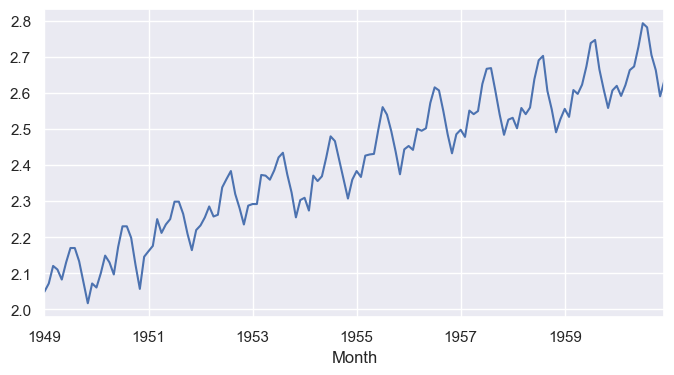

In [41]:
df['log10(Passengers)'] = np.log10(df['Passengers'])
df['log10(Passengers)'].plot();

Logaritmovanjem smo dobili nove podatke tako da magnituda sezonalnosti, cikliƒçnosti i ≈°uma ne zavisi od trenda ‚û°Ô∏è dobili smo aditivni model. 
Sada primenjujemo STL metod da vremensku seriju razdvojimo na komponente:

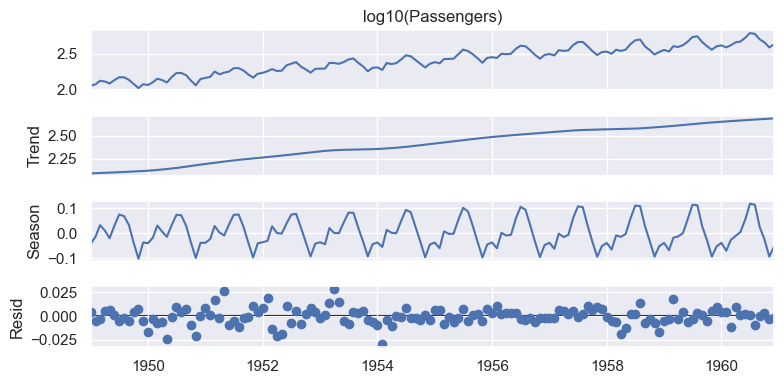

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(df['log10(Passengers)']).fit()
stl.plot()
plt.show()
# mogli smo i ruƒçno preuzeti vrednosti na sledeƒái naƒçin:
trend, seasonal, resid = stl.trend, stl.seasonal, stl.resid

Tumaƒçenje: Primenom STL metode rastavili smo vremensku seriju na komponente i vidimo da u podacima postoji trend i sezonalnost. 

<img style="float:right; max-width:400px" src="imgs/stationarity.png" width="40%" />

## Stacionarnost
Distribuciju opisuju statistiƒçke karakteristike (npr. **srednja vrednost, varijansa i kovarijansa**). Distribucija se ne menja kroz vreme kada su navedene statistiƒçke karakteristike konstantne. Stacionarnost znaƒçi da se distribucija ne menja kroz vreme tj. statistiƒçke karakteristike su konstantne. Za prediktivne modele (koje radimo u nastavku) neophodno je da su podaci stacionarni. Veƒáina modela i tehnika zahteva stacionarnu vremensku seriju. Ako vremenska serija nije stacionarna, moramo je transformisati tako da dobijemo stacionarnost.

Za testiranje stacionarnosti koristimo ADF test (*Augmented Dickey‚ÄìFuller*). Sa 95% taƒçnosti (p-vrednost ‚â§ 0.05) tvrdimo da je vremenska serija stacionarna kada je ADF ‚â§ -2.862. Umesto ADF vrednosti mo≈æemo koristiti p-vrednost. Ako je konkretna `p-vrednost ‚â§ 0.05` => 95% smo sigurni da je vremenska serija stacionarna ‚úÖ.

U na≈°em primeru sa brojem putnika, vremenska serija nije stacionarna. Proveriƒáemo stacionarnost ADF testom u nastavku, gde vidimo da je p-vrednost velika i nismo dobili stacionarnu vremensku seriju.


adf_value=0.82, p_value=0.99
ne postoji stacionarnost


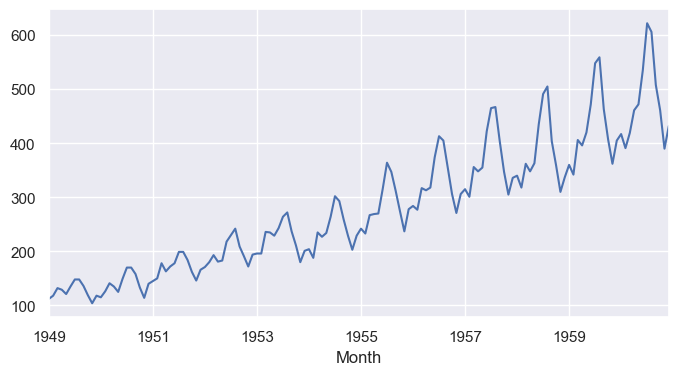

In [43]:
df['Passengers'].plot();
from statsmodels.tsa.stattools import adfuller
adf_value = adfuller(df['Passengers'])[0] 
p_value = adfuller(df['Passengers'])[1]
print(f'{adf_value=:.2f}, {p_value=:.2f}')

if p_value <= 0.05: print('postoji stacionarnost')
else: print('ne postoji stacionarnost')

### Postizanje stacionarnosti
- Srednju vrednost re≈°avamo: 1. uklanjanjem trenda ili 2. diferenciranjem.  
- Varijansu i kovarijansu re≈°avamo: 1. uklanjanjem sezonalnosti ili 2. diferenciranjem ili 3.  logaritmovanjem.

*Diferenciranje - tra≈æenje izvoda za vremensku seriju.*

Na≈°a vremenska serija ima sva 3 problema. Da bi ih re≈°ili, za poƒçetak ƒáemo logaritmovati podatke (to smo veƒá uradili pre STL metode). 
Sa grafika vidimo da smo re≈°ili problem varijanse i kovarijanse (skoro pa je potpuno konstantno), ≈°to je odliƒçno ‚úÖ.
Iako jo≈° uvek nije postignuta stacionarnost, vidimo da se p-vrednost smanjila, ≈°to znaƒçi da smo na dobrom putu.

adf_value=-1.72, p_value=0.42
ne postoji stacionarnost


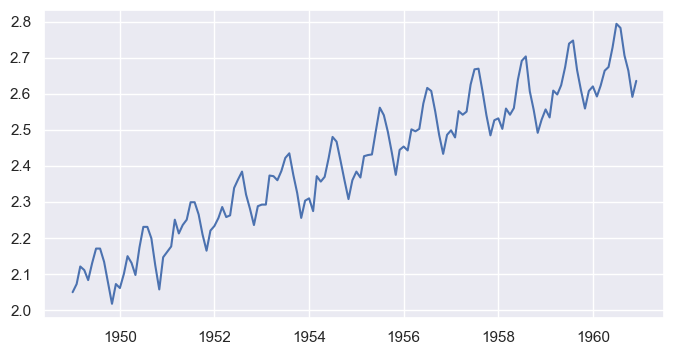

In [44]:
stationary_data = df['log10(Passengers)'].copy() # duboka kopija da ne menjamo kolonu
plt.plot(stationary_data);

adf_value = adfuller(df['log10(Passengers)'])[0] 
p_value = adfuller(df['log10(Passengers)'])[1]
print(f'{adf_value=:.2f}, {p_value=:.2f}')

if p_value <= 0.05: print('postoji stacionarnost')
else: print('ne postoji stacionarnost')

ƒåini se da je logaritmovanje re≈°ilo dva problema stacionarnosti - varijansu i kovarijansu. 
Fali jo≈° i konstantna srednja vrednost kako bi dobili stacionarnost, ≈°to mo≈æemo re≈°iti uklanjanjem trenda ili diferenciranjem.

p_value=0.03
postoji stacionarnost


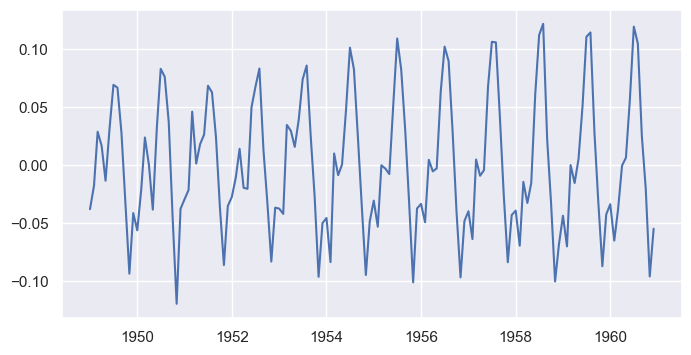

In [45]:
# 1. naƒçin - uklanjamo trend
stationary_data = df['log10(Passengers)'] - trend
p_value = adfuller(stationary_data)[1]
print(f'{p_value=:.2f}')
if p_value <= 0.05: print('postoji stacionarnost')
else: print('ne postoji stacionarnost')
plt.plot(stationary_data);

Uklanjanje trenda je re≈°ilo problem srednje vrednosti i dobili smo stacionarnost. Probaƒáemo sada da re≈°imo srednju vrednost na drugi naƒçin - diferenciranjem.

p_value=0.07
ne postoji stacionarnost


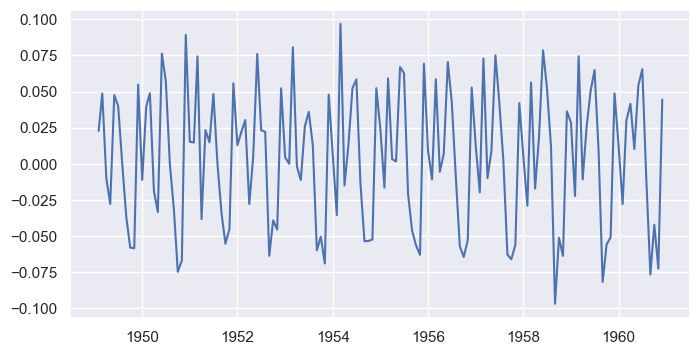

In [46]:
# 2. naƒçin - diferenciranje pozivom funkcije `diff()`
stationary_data = df['log10(Passengers)'].diff().dropna()
p_value = adfuller(stationary_data)[1]
print(f'{p_value=:.2f}')
if p_value <= 0.05: print('postoji stacionarnost')
else: print('ne postoji stacionarnost')
plt.plot(stationary_data);

Iako je p-vrednost vrlo blizu praga od 5%, trenutno jo≈° uvek nema stacionarnosti nakon diferenciranja jer nije ispod praga. 
Mo≈æemo jo≈° jednom da primenimo diferenciranje:

*Napomena: u praksi uglavnom ne treba diferencirati vi≈°e od 3 puta, jer ƒáe se izgubuti puno podataka.*

p_value=0.00
postoji stacionarnost


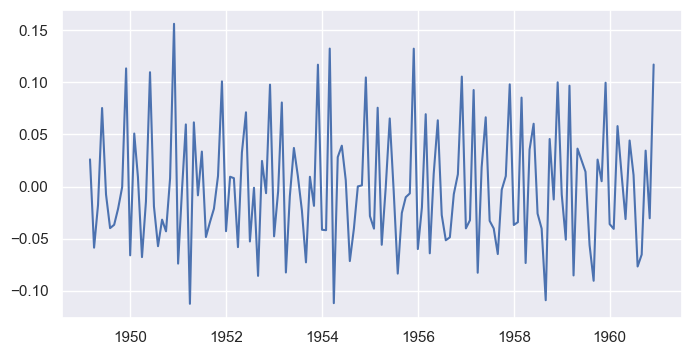

In [47]:
# 2. naƒçin - 2x diferenciranje `diff().diff()`
stationary_data = df['log10(Passengers)'].diff().diff().dropna()
p_value = adfuller(stationary_data)[1]
print(f'{p_value=:.2f}')
if p_value <= 0.05: print('postoji stacionarnost')
else: print('ne postoji stacionarnost')
plt.plot(stationary_data);

## Zadaci
**TODO 1**: Uƒçitaj vremensku seriju za broj putnika koristeƒái [data/airline-passengers.csv](data/airline-passengers.csv) i izdvoji podatke od 1954. do 1960. godine (ne uzimajuci ni jedan datum iz 1960). Zatim:
1. nacrtaj grafik vremenske seirje,
1. Utvrdi da li se podaci mogu modelovati kao vremenska serija,
1. Utvrdi koji prethodni meseci imaju direktan uticaj na trenutni,
1. Razdvoji vremensku seriju na komponente i nacrtaj grafik komponenti,
1. Rekonstrui≈°i i nacrtaj originalnu vremensku seriju koristeƒái samo podatke o trendu, sezonalnosti i ≈°umu.
1. Postigni stacionarnost sa sigurno≈°ƒáu od 99% bez upotrebe diferenciranja.